# Model details
- Trained with 685k unique vectors (words) with 300 dimensions each
- Language data was from OntoNotes - news, conversational telephone speech, weblogs, usenet newsgroups, broadcast, talk shows
    - https://catalog.ldc.upenn.edu/LDC2013T19

# Imports

In [29]:
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
import spacy
import nltk
from nltk.tokenize import wordpunct_tokenize
from autocorrect import Speller
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tweepy
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Get bios from Twitter

In [3]:
api_key = "Uroihphf25vaDmGPadvG1klrU"
api_secret_key = "mpQ6yDaGmdiyPW6ytzEo5nrw8SZn94YZKtMnx3tx13RQj7HoYs"
bearer_token = "AAAAAAAAAAAAAAAAAAAAAORhNAEAAAAAR1ODpBlt9PHGImWMWE8WxxfRHhY%3D0UDIDDI9ARsdZzFo4Pf7jrVdlIdzgqz1CDWcoYCGdm42jieyLR"
access_token = "889954860329730048-7mBJQPfciA1pva5Olpovd22deE8hplo"
access_token_secret = "FGy9LvHHZt6X6W1umPugGlgPJsdWpUjH9Eu4re9ozxNEz"

auth = tweepy.OAuthHandler(api_key, api_secret_key)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

In [11]:
queries = [
    "neuroscience",
    "entertainment",
    "finance",
    "fitness"
]
usernames = np.unique([user.screen_name for q in queries for user in api.search_users(q)])
profiles = [api.get_user(user).description for user in usernames]

# Process bio data

In [12]:
def remove_words_with_char(char: str, sentence: str):
    return " ".join(filter(lambda x:x[0]!=char, sentence.split()))

In [13]:
# tokenize, conver to lower case, remove non words and stop words, autocorrect
spell = Speller()
stop_words = np.unique(stopwords.words('english') + ["the"])
proc_profiles = []
for prof in profiles:
    # remove anything with @ in front
    tokens = wordpunct_tokenize(remove_words_with_char("@",prof))
    processed_profile = []
    for word in tokens:
        cleaned_word = spell(word.lower())
        if cleaned_word.isalpha() and cleaned_word not in stop_words:
            processed_profile.append(cleaned_word)
    proc_profiles.append(processed_profile)

# Generate bio embeddings with spacy's model

In [14]:
# load model
nlp = spacy.load("en_core_web_lg")
# turn tokenized profiles back into full sentence to embed
full_profiles = [" ".join(prof) for prof in proc_profiles]
# calculate average word embedding for each profile
ave_embeddings = np.array([nlp(prof).vector for prof in full_profiles])

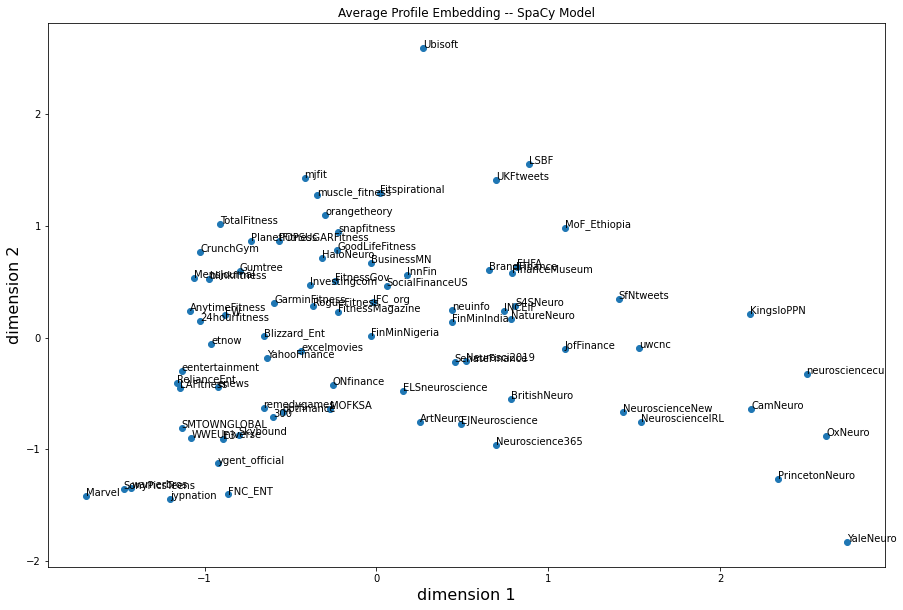

In [28]:
# visualize ave. profile embeddings
pca = PCA(n_components=2)
embed_2d = pca.fit_transform(ave_embeddings)

plt.figure(figsize=(15,10))
plt.scatter(embed_2d[:, 0], embed_2d[:, 1])
for i, user in enumerate(usernames):
    plt.annotate(user, xy=(embed_2d[i, 0], embed_2d[i, 1]))
plt.xlabel("dimension 1",fontsize=16)
plt.ylabel("dimension 2",fontsize=16)
plt.title("Average Profile Embedding -- SpaCy Model")
plt.show()

# Cluster profiles based on category

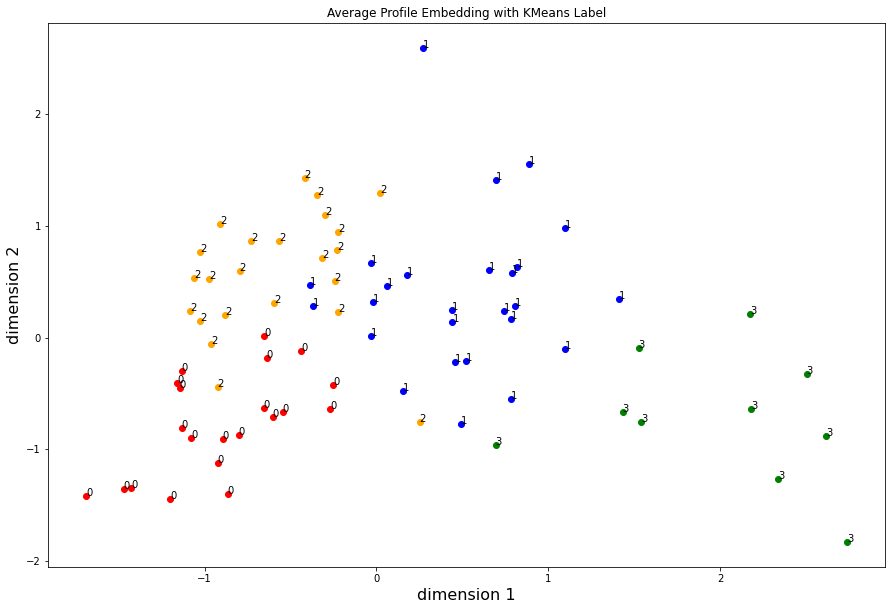

In [35]:
# cluster embeddings based on category
kmeans = KMeans(n_clusters=len(queries), random_state=0)
preds = kmeans.fit_predict(ave_embeddings)

color_map = {i:c for i,c in zip(range(len(queries)),["red","blue","orange","green"])}

plt.figure(figsize=(15,10))
for i, pred in enumerate(preds):
    plt.scatter(embed_2d[i, 0], embed_2d[i, 1], color=color_map[pred])
    plt.annotate(pred, xy=(embed_2d[i, 0], embed_2d[i, 1]))
plt.xlabel("dimension 1",fontsize=16)
plt.ylabel("dimension 2",fontsize=16)
plt.title("Average Profile Embedding with KMeans Label")
plt.show()

# Compute similarity between users

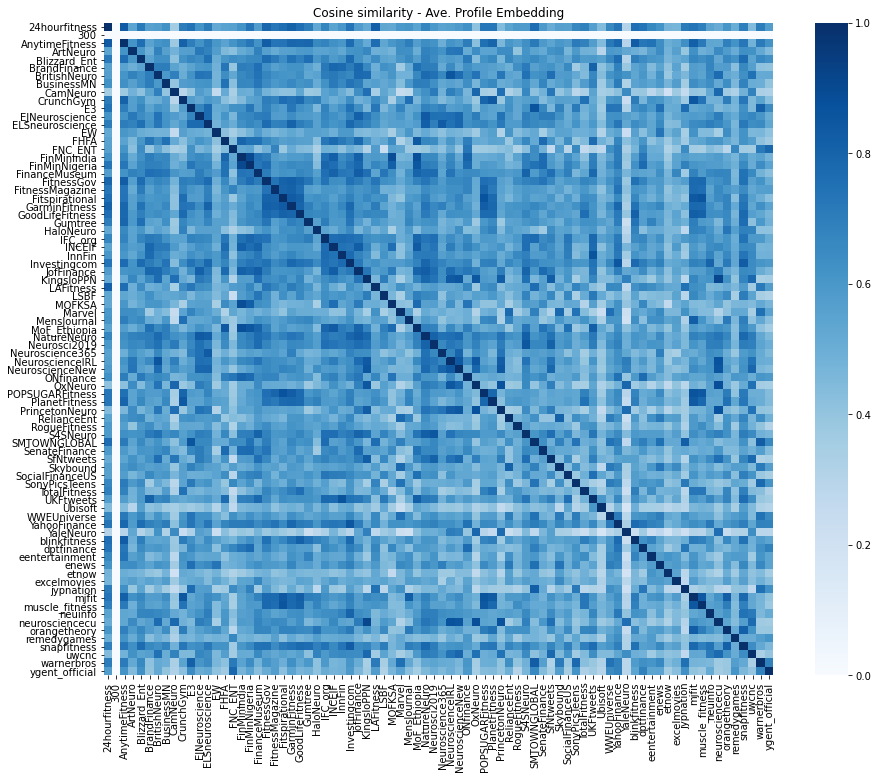

In [15]:
# compute similarity
cos_similarity = cosine_similarity(ave_embeddings)
plt.figure(figsize=(15,12))
sns.heatmap(cos_similarity,cmap="Blues",xticklabels=usernames,yticklabels=usernames)
plt.title("Cosine similarity - Ave. Profile Embedding")
plt.show()

# Create recommendations based on similarity

In [16]:
def similarity_rankings(users, similarity_scores, num_recs: int=5) -> pd.DataFrame:
    user_recs_dict = {"user":[],"recommendation":[],"score":[], "ranking":[]}
    for i,user in enumerate(users):
        # get sim scores and remove current user
        curr_sim_scores = np.delete(similarity_scores[i].copy(),i)
        curr_users = np.delete(np.array(users.copy()),i)
        # get recs
        for i in range(num_recs):
            user_recs_dict["user"].append(user)
            # current most similar user and score
            top_sim_idx = np.argmax(curr_sim_scores)
            top_sim_user = curr_users[top_sim_idx]
            top_sim_score = curr_sim_scores[top_sim_idx]
            user_recs_dict["recommendation"].append(top_sim_user)
            user_recs_dict["score"].append(top_sim_score)
            user_recs_dict["ranking"].append(i+1)
            # remove from lists
            curr_sim_scores = np.delete(curr_sim_scores,top_sim_idx)
            curr_users = np.delete(curr_users,top_sim_idx)

    user_recs = pd.DataFrame.from_dict(user_recs_dict)
    return user_recs

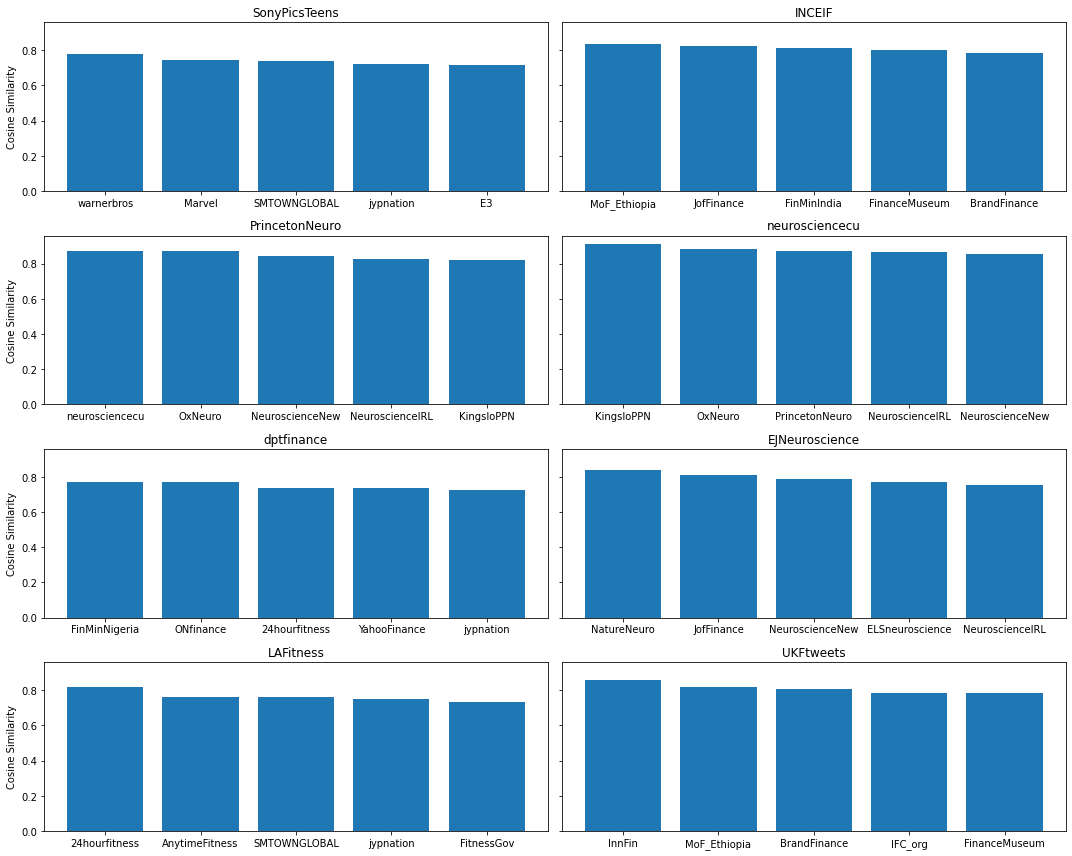

In [18]:
user_recs = similarity_rankings(usernames, cos_similarity)
rand_users = np.random.choice(usernames,size=8,replace=False)
fig,axes = plt.subplots(4,2,figsize=(15,12),sharey=True)
for i,(user,ax) in enumerate(zip(rand_users,np.ravel(axes))):
    curr_user = user_recs[user_recs["user"]==user]
    ax.bar(curr_user.recommendation,curr_user.score)
    ax.set_title(user)
    ax.set_ylabel("Cosine Similarity") if not i%2 else ax.set_ylabel("")
plt.tight_layout()
plt.show()